In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import glob

In [148]:
all_x_files = glob.glob("simulations_etazero/data_x*")
thetas = torch.zeros((len(all_x_files),7))
labels = torch.zeros((len(all_x_files),1))

for i,file in enumerate(all_x_files):
    run_label = file[34:]
    xnew = torch.load(file)
    thetas[i,:] = xnew
    hist = torch.load("simulations_etazero/data_y_mult_hist_"+run_label)
    if torch.sum(hist,dim=1)>=108013:
        labels[i,:] = 1

shuffle_mask =  torch.randperm(thetas.size()[0])
thetas=thetas[shuffle_mask]
labels=labels[shuffle_mask]

In [149]:
class Emulator(nn.Module):
    def __init__(self):
        super(Emulator, self).__init__()
        
        # Define the layers
        self.fc1 = nn.Linear(6, 64)     
        self.fc2 = nn.Linear(64, 32)  
        self.fc3 = nn.Linear(32, 1)
                             
        # Activation function
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        x = self.relu(self.fc1(x))      
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)      
        x = self.sigmoid(self.fc3(x))

        return x



model = Emulator()

learning_rate = 0.0001
num_epochs = 500
batch_size = 16
train_percent = 0.8
train_size = int(len(thetas)*train_percent)
step_size = 400

criterion = nn.BCELoss()  
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,step_size)

norm_factor = (torch.max(thetas,dim=0)[0])

inputs = thetas[:train_size,:-1]/norm_factor[:-1]
targets = labels[:train_size]

inputs_val = thetas[train_size:,:-1]/norm_factor[:-1]
targets_val = labels[train_size:]

dataset = torch.utils.data.TensorDataset(inputs, targets)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

dataset_val = torch.utils.data.TensorDataset(inputs_val, targets_val)
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)



In [ ]:
train_losses = []
val_losses = []
min_val_loss = 10000000
train_acc = []
val_acc = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_correct = 0
    total_train = 0

    model.train()
    for batch_inputs, batch_targets in data_loader:
       
        outputs = model(batch_inputs)
        
        loss = torch.mean(criterion(outputs, batch_targets),dim=0)
        
        optimizer.zero_grad()  
        
        loss.backward()        
 
        optimizer.step()       
 
        running_loss  += loss.item()
        scheduler.step()
        preds = (outputs >= 0.5).float()
        running_correct += (preds == batch_targets).sum().item()
        total_train += batch_targets.numel()

    train_accuracy = running_correct / total_train
    train_acc.append(train_accuracy)

    running_loss_val  = 0.0
    running_acc_val = 0.0
    running_correct_val = 0
    total_val = 0

    with torch.no_grad():
        model.eval()
        for batch_inputs, batch_targets in data_loader_val:
            
            outputs = model(batch_inputs)
            loss = torch.mean(criterion(outputs, batch_targets),dim=0)
            running_loss_val  += loss.item()
            preds = (outputs >= 0.5).float()
            running_correct_val += (preds == batch_targets).sum().item()
            total_val += batch_targets.numel()

    val_accuracy = running_correct_val / total_val
    val_acc.append(val_accuracy)


    train_losses.append(running_loss / len(data_loader))
    val_losses.append(running_loss_val / len(data_loader_val))

    if running_loss_val / len(data_loader_val) < min_val_loss :
        min_val_loss  = running_loss_val / len(data_loader_val)
        best_model  = model
        torch.save(best_model .state_dict(), "best_model_0_or_1")
    # Print loss for each epoch
    
    avg_loss = running_loss  / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, "
          f"Val Acc: {val_accuracy:.4f}")


print("Training complete!")

Epoch [1/500], Loss: 0.6405, Val Loss: 0.6036, Train Acc: 0.6578, Val Acc: 0.6962
Epoch [2/500], Loss: 0.6242, Val Loss: 0.6019, Train Acc: 0.6912, Val Acc: 0.6962
Epoch [3/500], Loss: 0.6181, Val Loss: 0.5915, Train Acc: 0.6998, Val Acc: 0.6962
Epoch [4/500], Loss: 0.6084, Val Loss: 0.5902, Train Acc: 0.6957, Val Acc: 0.6962
Epoch [5/500], Loss: 0.6068, Val Loss: 0.5809, Train Acc: 0.6989, Val Acc: 0.6962
Epoch [6/500], Loss: 0.5917, Val Loss: 0.5785, Train Acc: 0.7021, Val Acc: 0.6962
Epoch [7/500], Loss: 0.5887, Val Loss: 0.5679, Train Acc: 0.7023, Val Acc: 0.6962
Epoch [8/500], Loss: 0.5744, Val Loss: 0.5606, Train Acc: 0.7038, Val Acc: 0.6962
Epoch [9/500], Loss: 0.5694, Val Loss: 0.5548, Train Acc: 0.7045, Val Acc: 0.6962
Epoch [10/500], Loss: 0.5593, Val Loss: 0.5417, Train Acc: 0.7072, Val Acc: 0.6962
Epoch [11/500], Loss: 0.5551, Val Loss: 0.5388, Train Acc: 0.7079, Val Acc: 0.6962
Epoch [12/500], Loss: 0.5451, Val Loss: 0.5246, Train Acc: 0.7111, Val Acc: 0.6962
Epoch [13/500

Text(0.5, 0, 'epoch')

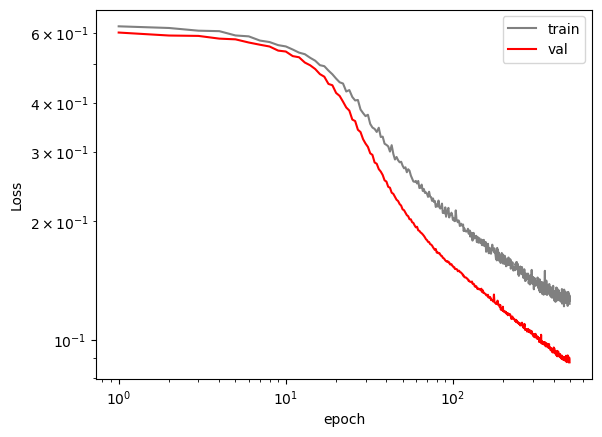

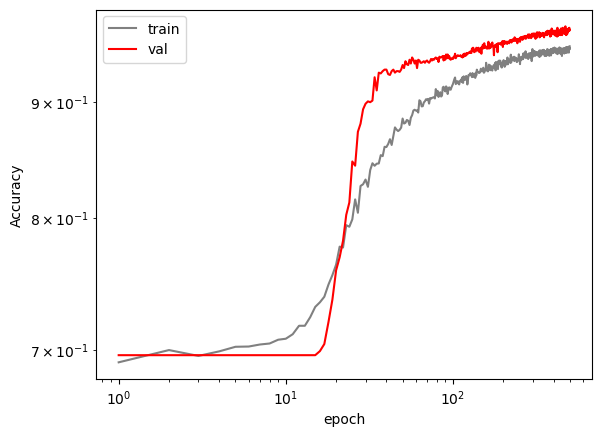

In [151]:
plt.figure()

plt.loglog(range(1,num_epochs),train_losses[1:],color="gray",label="train")
plt.loglog(range(1,num_epochs),val_losses[1:],color="red",label="val")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("epoch")

plt.figure()
plt.loglog(range(1,num_epochs),train_acc[1:],color="gray",label="train")
plt.loglog(range(1,num_epochs),val_acc[1:],color="red",label="val")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("epoch")